# Problem Statement


- How can be best predict the housing prices by deep-cleaning our data? 
- Before fitting various models, what are some important feature engineering steps that can be done for better modeling? 

# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [3]:
from scipy import stats  
from sklearn.metrics import r2_score, mean_squared_error 


## Initial inspection

- import data, check shape, investigate data types

In [76]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
train.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [66]:
train.shape

(2051, 81)

In [67]:
test.shape

(878, 80)

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

## Missing values 
- how many missing values are there? 
- how big is the percentage of the missing data in the columns?

In [9]:
train.isnull().sum().sort_values(ascending=False).head(30)


Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
Overall Cond         0
Exterior 2nd         0
Exterior 1st         0
Roof Matl            0
dtype: int64

In [69]:
train.isnull().mean().sort_values(ascending=False).head(30)


Pool QC           0.995612
Misc Feature      0.968308
Alley             0.931741
Fence             0.804973
Fireplace Qu      0.487567
Lot Frontage      0.160897
Garage Finish     0.055583
Garage Cond       0.055583
Garage Qual       0.055583
Garage Yr Blt     0.055583
Garage Type       0.055095
Bsmt Exposure     0.028279
BsmtFin Type 2    0.027304
BsmtFin Type 1    0.026816
Bsmt Cond         0.026816
Bsmt Qual         0.026816
Mas Vnr Type      0.010726
Mas Vnr Area      0.010726
Bsmt Half Bath    0.000975
Bsmt Full Bath    0.000975
Garage Cars       0.000488
Garage Area       0.000488
Bsmt Unf SF       0.000488
BsmtFin SF 2      0.000488
Total Bsmt SF     0.000488
BsmtFin SF 1      0.000488
Overall Cond      0.000000
Exterior 2nd      0.000000
Exterior 1st      0.000000
Roof Matl         0.000000
dtype: float64

## Distributions

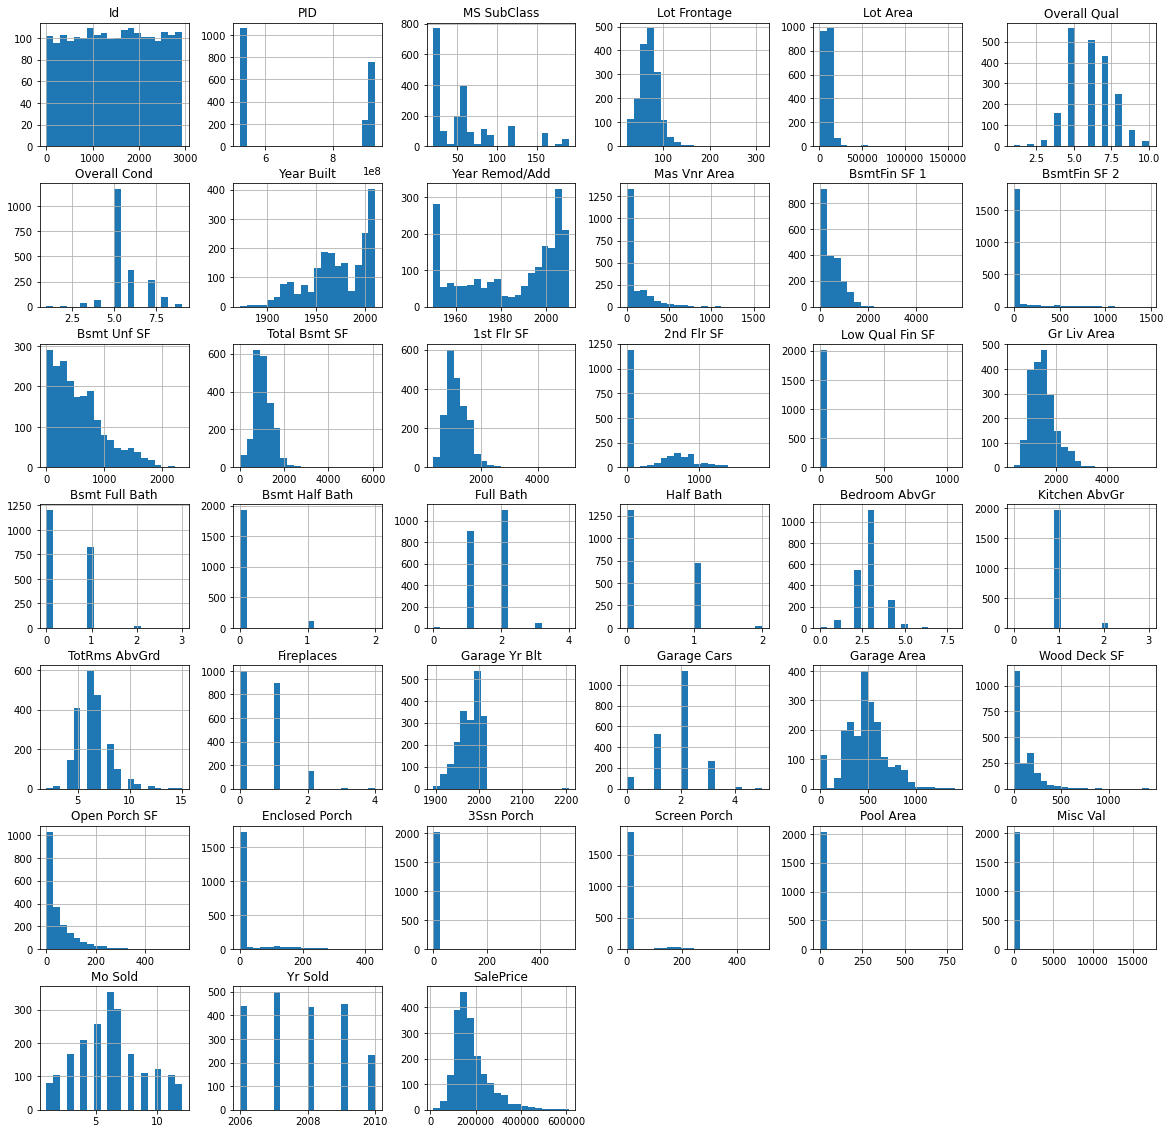

In [11]:
train.hist(figsize=(20,20), bins=20);

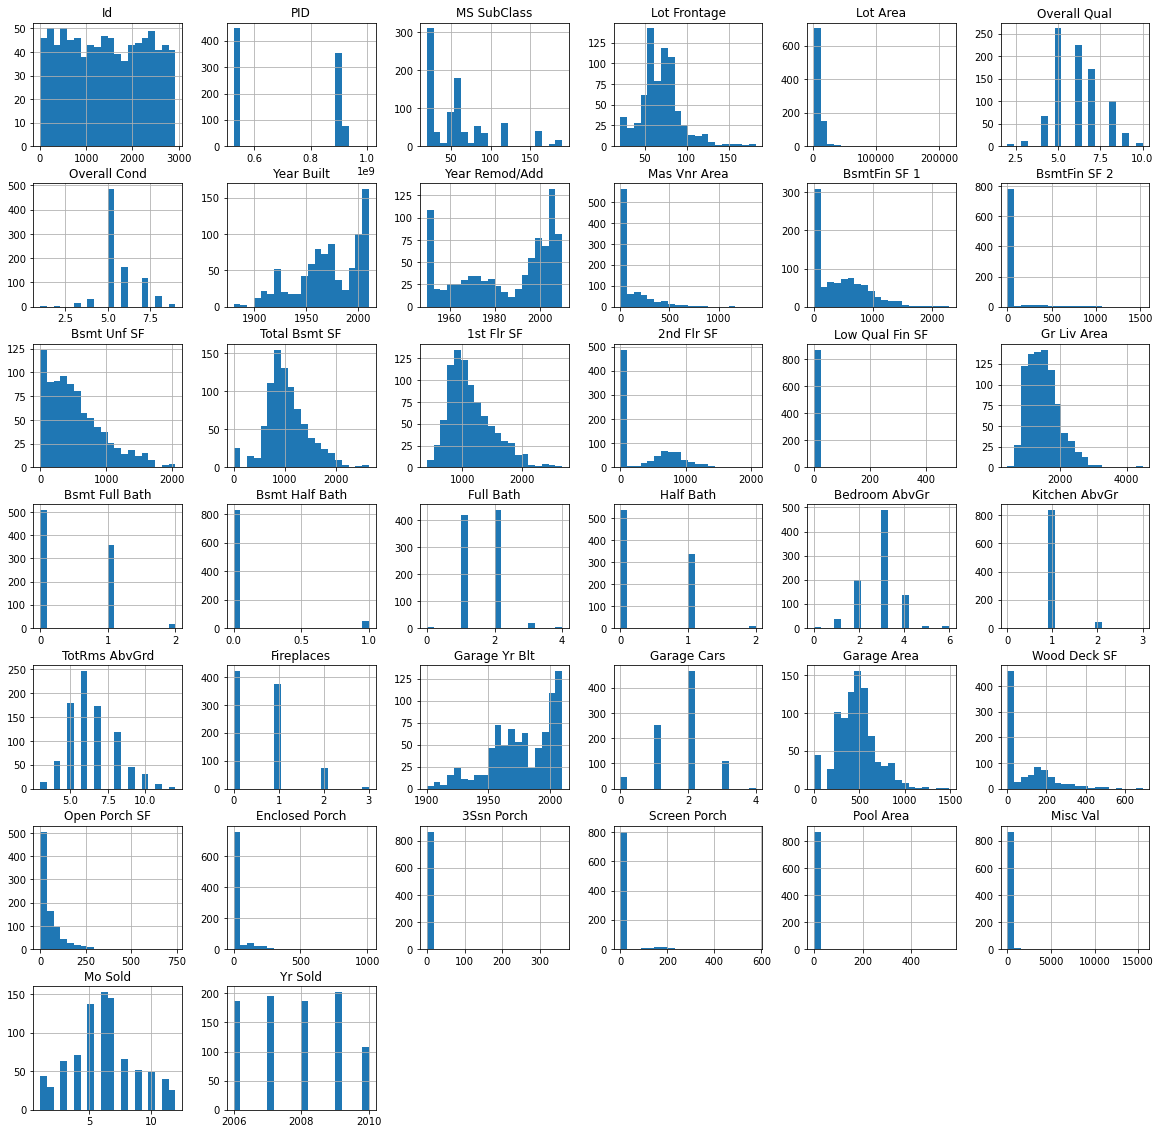

In [12]:
test.hist(figsize=(20,20), bins=20);

- in general, the distribution of the train vs. test looks very comparable with a few exceptions.


## Outliers


- outliers in the train set not present in the test set 
    - lot frontage
    - total bsmt SF
    - 1st fir sf
    - garage yr built
    - wood deck sf
- SalePrice - does not follow standard distribution

In [70]:
train.corr()

Id       PID  MS SubClass  Lot Frontage  Lot Area  \
Id               1.000000  0.175793     0.026543     -0.024967  0.032872   
PID              0.175793  1.000000    -0.003632     -0.091291  0.024135   
MS SubClass      0.026543 -0.003632     1.000000     -0.389790 -0.245484   
Lot Frontage    -0.024967 -0.091291    -0.389790      1.000000  0.574024   
Lot Area         0.032872  0.024135    -0.245484      0.574024  1.000000   
Overall Qual    -0.061483 -0.265863     0.035763      0.194808  0.105824   
Overall Cond    -0.026096  0.106861    -0.070141     -0.054455 -0.019185   
Year Built      -0.064444 -0.347039     0.035983      0.109504  0.036002   
Year Remod/Add  -0.090040 -0.176666     0.044836      0.085052  0.050771   
Mas Vnr Area    -0.035493 -0.247959    -0.004047      0.218218  0.169379   
BsmtFin SF 1    -0.045878 -0.086522    -0.060854      0.214178  0.215430   
BsmtFin SF 2     0.000723 -0.013144    -0.068265      0.036740  0.041717   
Bsmt Unf SF      0.008555 -0.111281    -0.139911      0.127605  0.041184   
Total Bsmt SF   -0.038346 -0.203795    -0.226038      0.356584  0.277175   
1st Flr SF      -0.022650 -0.145862    -0.246212      0.463900  0.381593   
2nd Flr SF      -0.008388 -0.005598     0.305771      0.013700  0.029398   
Low Qual Fin SF  0.011719  0.072268     0.031091     -0.000300  0.001273   
Gr Liv Area     -0.023881 -0.112936     0.068210      0.383856  0.327427   
Bsmt Full Bath  -0.033385 -0.030554     0.025055      0.111441  0.116128   
Bsmt Half Bath   0.014381 -0.001946    -0.017249     -0.030858  0.029980   
Full Bath       -0.059086 -0.179370     0.142087      0.152812  0.125601   
Half Bath       -0.042054 -0.163975     0.179404      0.035842  0.049995   
Bedroom AbvGr    0.010605  0.009122    -0.003516      0.220414  0.139060   
Kitchen AbvGr   -0.002400  0.068416     0.252111      0.015856 -0.013484   
TotRms AbvGrd   -0.009092 -0.084999     0.034490      0.362704  0.238724   
Fireplaces      -0.037560 -0.120710    -0.055118      0.253456  0.289467   
Garage Yr Blt   -0.050730 -0.251257     0.084954      0.067865  0.004882   
Garage Cars     -0.048666 -0.228368    -0.049148      0.297143  0.214954   
Garage Area     -0.045201 -0.200891    -0.108228      0.358457  0.263296   
Wood Deck SF    -0.009045 -0.041221     0.001622      0.115180  0.155623   
Open Porch SF    0.001382 -0.081129    -0.020289      0.184958  0.140864   
Enclosed Porch   0.033747  0.150179    -0.039842     -0.003302  0.014139   
3Ssn Porch      -0.022791 -0.024679    -0.030088      0.031855  0.019553   
Screen Porch     0.009758 -0.042030    -0.038819      0.074819  0.067714   
Pool Area        0.055696  0.005825    -0.004585      0.156575  0.115102   
Misc Val        -0.012683  0.004223    -0.027485      0.051676  0.093922   
Mo Sold          0.127723 -0.032735     0.013027     -0.017389  0.003197   
Yr Sold         -0.975747  0.008476    -0.032870      0.009112 -0.029454   
SalePrice       -0.051398 -0.255052    -0.087335      0.341842  0.296566   

                 Overall Qual  Overall Cond  Year Built  Year Remod/Add  \
Id                  -0.061483     -0.026096   -0.064444       -0.090040   
PID                 -0.265863      0.106861   -0.347039       -0.176666   
MS SubClass          0.035763     -0.070141    0.035983        0.044836   
Lot Frontage         0.194808     -0.054455    0.109504        0.085052   
Lot Area             0.105824     -0.019185    0.036002        0.050771   
Overall Qual         1.000000     -0.082770    0.602964        0.584654   
Overall Cond        -0.082770      1.000000   -0.370988        0.042614   
Year Built           0.602964     -0.370988    1.000000        0.629116   
Year Remod/Add       0.584654      0.042614    0.629116        1.000000   
Mas Vnr Area         0.438685     -0.135878    0.329741        0.211443   
BsmtFin SF 1         0.278742     -0.045768    0.275440        0.166680   
BsmtFin SF 2        -0.028199      0.047810   -0.021031       -0.057163   
Bsmt Un

In [5]:
numeric_col = train._get_numeric_data().columns
numeric_train = train[numeric_col]
numeric_col_list = list(numeric_train.columns)
    

In [72]:
train[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(50)


SalePrice          1.000000
Overall Qual       0.800207
Gr Liv Area        0.697038
Garage Area        0.650270
Garage Cars        0.648220
Total Bsmt SF      0.628925
1st Flr SF         0.618486
Year Built         0.571849
Year Remod/Add     0.550370
Full Bath          0.537969
Garage Yr Blt      0.533922
Mas Vnr Area       0.512230
TotRms AbvGrd      0.504014
Fireplaces         0.471093
BsmtFin SF 1       0.423519
Lot Frontage       0.341842
Open Porch SF      0.333476
Wood Deck SF       0.326490
Lot Area           0.296566
Bsmt Full Bath     0.283662
Half Bath          0.283001
2nd Flr SF         0.248452
Bsmt Unf SF        0.190210
Bedroom AbvGr      0.137067
Screen Porch       0.134581
3Ssn Porch         0.048732
Mo Sold            0.032735
Pool Area          0.023106
BsmtFin SF 2       0.016255
Misc Val          -0.007375
Yr Sold           -0.015203
Low Qual Fin SF   -0.041594
Bsmt Half Bath    -0.045328
Id                -0.051398
MS SubClass       -0.087335
Overall Cond      -0

In [6]:
top20corr = train[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(21)
top20corr = top20corr.iloc[1:]
top20corr.index

Index(['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage', 'Open Porch SF',
       'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath', 'Half Bath'],
      dtype='object')

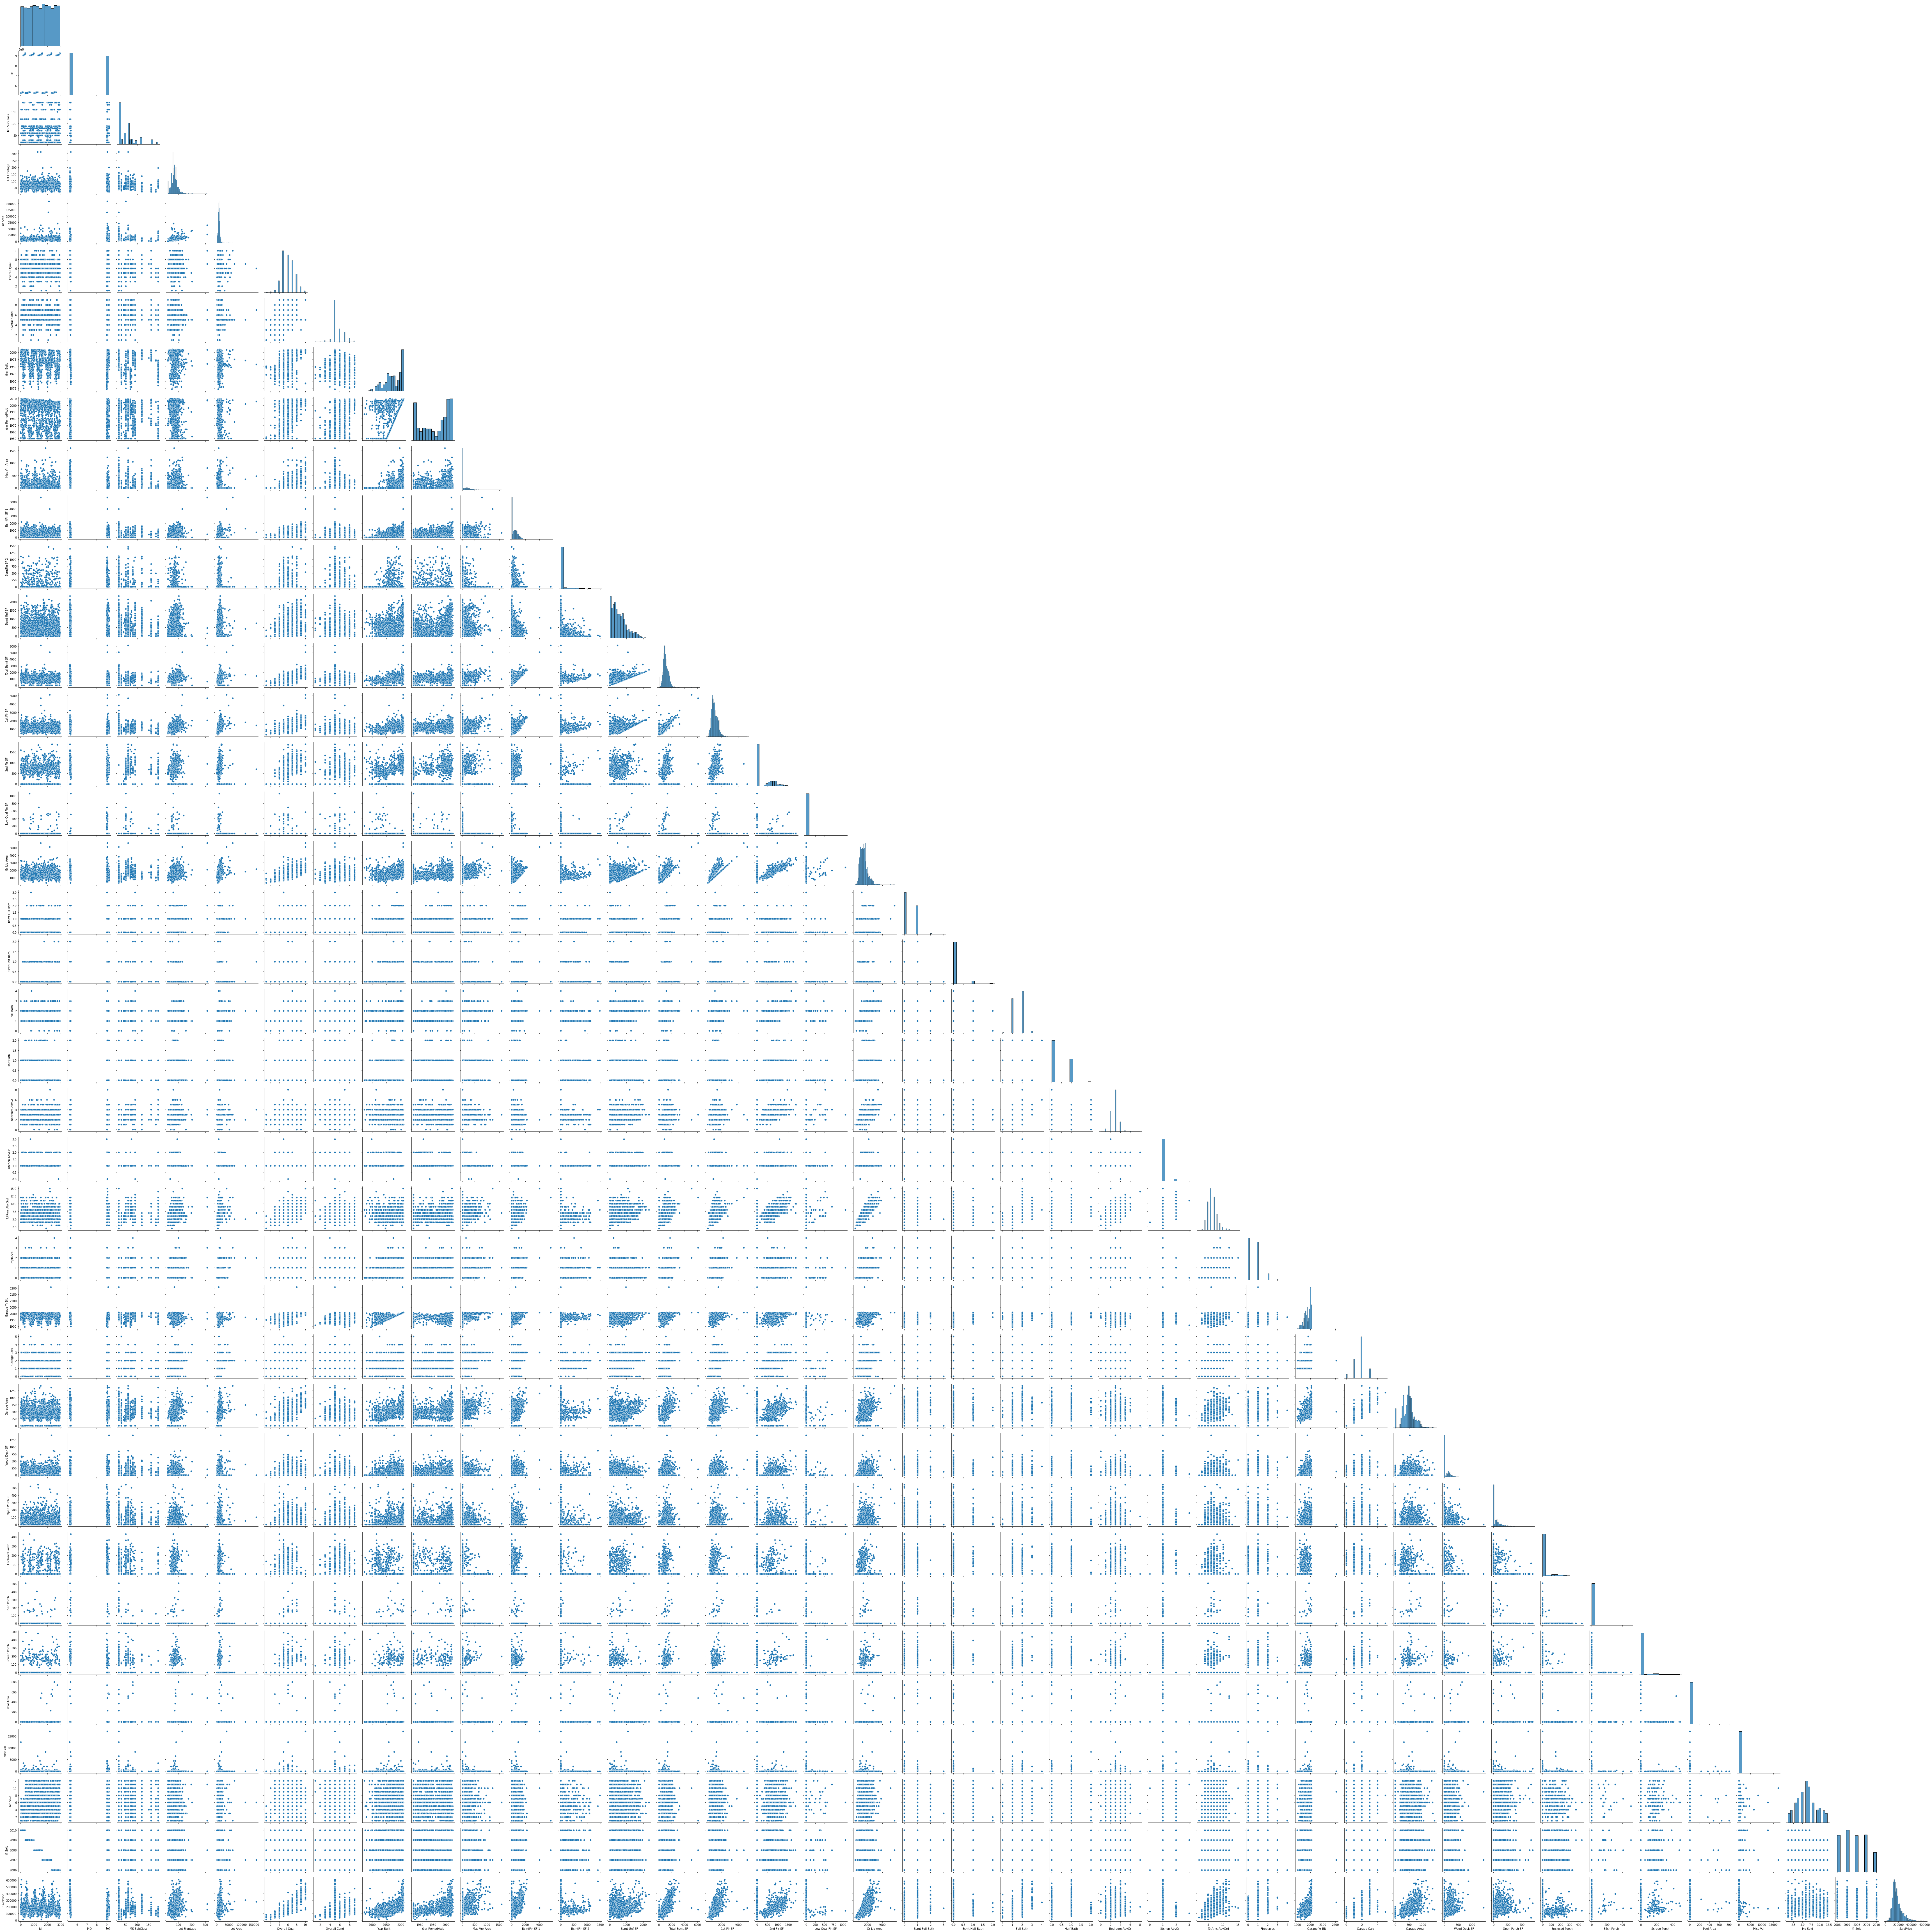

In [17]:
# Show the results of a linear regression within each dataset
sns.pairplot(numeric_train, corner=True);

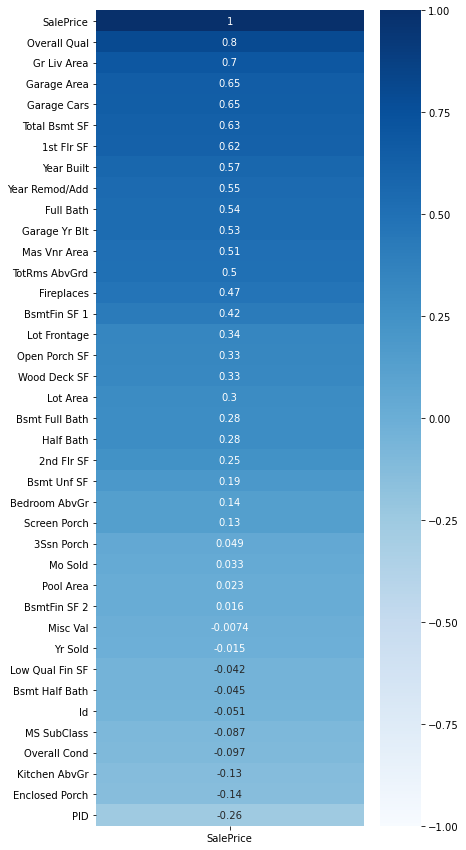

In [18]:
# adapted from Adi's Feature Engineering solutionsfig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.figure(figsize=(6,15))
sns.heatmap(numeric_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False),
           annot=True,
           vmin=-1, vmax=1,
           cmap='Blues');

<AxesSubplot:>

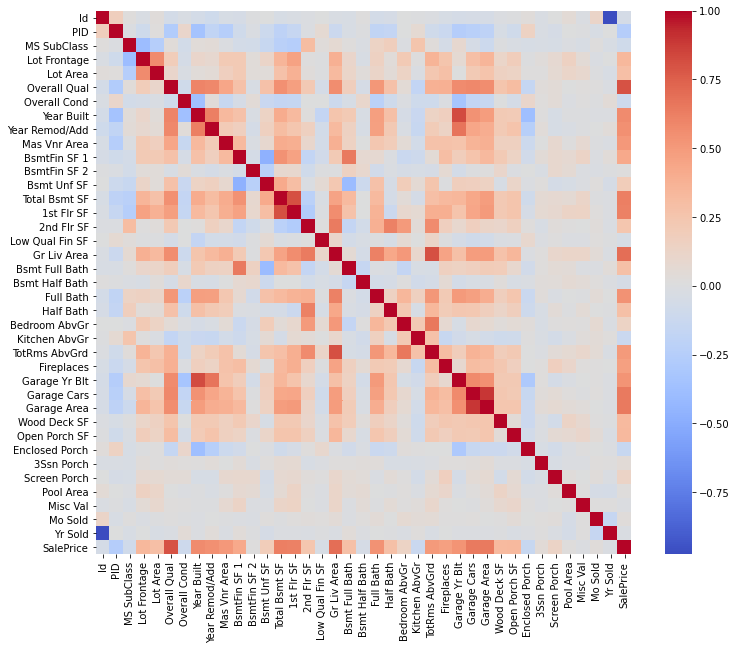

In [19]:

plt.subplots(figsize=(12,10))
sns.heatmap(train.corr(), cmap="coolwarm")

## Summary statistics

In [74]:
train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [75]:
test.describe()

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count   878.000000  8.780000e+02   878.000000    718.000000     878.000000   
mean   1444.749431  7.162867e+08    58.268793     69.545961   10307.033030   
std     850.838263  1.889103e+08    42.235407     23.533945   10002.674602   
min       2.000000  5.263021e+08    20.000000     21.000000    1477.000000   
25%     692.250000  5.284841e+08    20.000000     59.000000    7297.250000   
50%    1433.000000  5.354542e+08    50.000000     68.000000    9446.000000   
75%    2197.500000  9.071904e+08    70.000000     80.000000   11589.000000   
max    2928.000000  1.007100e+09   190.000000    182.000000  215245.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count    878.000000    878.000000   878.000000      878.000000    877.000000   
mean       6.050114      5.566059  1970.492027     1984.417995    106.236032   
std        1.369065      1.128903    30.395895       20.450725    187.158908   
min        2.000000      1.000000  1880.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1954.000000     1967.000000      0.000000   
50%        6.000000      5.000000  1972.000000     1992.000000      0.000000   
75%        7.000000      6.000000  1999.750000     2003.000000    172.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1378.000000   

       ...  Garage Area  Wood Deck SF  Open Porch SF  Enclosed Porch  \
count  ...   878.000000    878.000000     878.000000      878.000000   
mean   ...   470.362187     93.430524      47.070615       24.064920   
std    ...   212.734075    121.181702      68.180939       73.249463   
min    ...     0.000000      0.000000       0.000000        0.000000   
25%    ...   322.500000      0.000000       0.000000        0.000000   
50%    ...   473.000000      0.000000      27.000000        0.000000   
75%    ...   576.000000    170.750000      69.750000        0.000000   
max    ...  1488.000000    690.000000     742.000000     1012.000000   

       3Ssn Porch  Screen Porch   Pool Area      Misc Val     Mo Sold  \
count  878.000000    878.000000  878.000000    878.000000  878.000000   
mean     2.597950     14.830296    1.884966     48.498861    6.202733   
std     24.962482     53.003794   29.916672    550.169317    2.642498   
min      0.000000      0.000000    0.000000      0.000000    1.000000   
25%      0.000000      0.000000    0.000000      0.000000    5.000000   
50%      0.000000      0.000000    0.000000      0.000000    6.000000   
75%      0.000000      0.000000    0.000000      0.000000    8.000000   
max    360.000000    576.000000  555.000000  15500.000000   12.000000   

           Yr Sold  
count   878.000000  
mean   2007.825740  
std       1.327861  
min    2006.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2010.000000  

[8 rows x 38 columns]

## Modeling insights to investigate

- about 50% of features are categorical
- some distributions are heavily skewed/kurt, which can negatively affect regression model
- there are many missing values - too many to drop & lose other valuable information. 

# Preliminary LR Model Fitting and Evaluation

## using All non-Numeric Columns as OneHot

### set X and Y
### Fit the model

In [77]:
df = train
features = [col for col in df.columns if col not in numeric_col]
X = df[features]
X = pd.get_dummies(data=X, drop_first=True, columns=features)
y = df['SalePrice']
lr_all_dummies = LinearRegression()
lr_all_dummies.fit(X,y)
X.shape

(2051, 13382)

### R2 

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, train_size=0.8, random_state=42)
y_pred = lr_all_dummies.predict(X)

r2_score(y,y_pred)

0.8611506066336391

### RMSE

In [78]:
mean_squared_error(y,y_pred, squared=False)

29526.557511360512

### train/test/split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [80]:
linreg1 = LinearRegression()

In [81]:
linreg1.fit(X_train, y_train)

LinearRegression()

In [82]:
train_preds = linreg1.predict(X_train)
test_preds = linreg1.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

29098.259002446022

In [83]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

427047977228793.44

## using Top 20 Correlated Numeric Columns


### Filter out Top 20 most highly correlated numeric columns

In [10]:
top20corr = df[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(21)
top20corr = top20corr.iloc[1:]
top20corr.index

Index(['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage', 'Open Porch SF',
       'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath', 'Half Bath'],
      dtype='object')

### X, Y, fit, predict

In [11]:
features = top20corr.index
X = df[features]

In [12]:
X.fillna(0, inplace=True)
X.isnull().sum()

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Overall Qual      0
Gr Liv Area       0
Garage Area       0
Garage Cars       0
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
Garage Yr Blt     0
Mas Vnr Area      0
TotRms AbvGrd     0
Fireplaces        0
BsmtFin SF 1      0
Lot Frontage      0
Open Porch SF     0
Wood Deck SF      0
Lot Area          0
Bsmt Full Bath    0
Half Bath         0
dtype: int64

In [87]:
y = df['SalePrice']
lr_top20corr = LinearRegression()
lr_top20corr.fit(X,y)
y_pred = lr_top20corr.predict(X)
X.shape

(2051, 20)

### R2

In [88]:

r2_score(y,y_pred)

0.8166005133100932

### RMSE

In [89]:
# RMSE for testing
mean_squared_error(y, y_pred, squared=False)

33934.37699064142

### train/test/split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [91]:
linreg2 = LinearRegression()

In [92]:
linreg2.fit(X_train, y_train)

LinearRegression()

In [93]:
train_preds = linreg2.predict(X_train)
test_preds = linreg2.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

35196.52502880836

In [94]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

28947.921868985322

## using Top 10 Correlated Numeric Columns


### Filter out Top 10 most highly correlated numeric columns

In [13]:
top10corr = df[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(11)
top10corr = top10corr.iloc[1:]
top10corr.index

Index(['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Garage Yr Blt'],
      dtype='object')

### X, Y, fit, predict

In [14]:
features = top10corr.index
X = df[features]
X.fillna(0, inplace=True)
y = df['SalePrice']
lr_top10corr = LinearRegression()
lr_top10corr.fit(X,y)
y_pred = lr_top10corr.predict(X)
X.shape


/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


(2051, 10)

### R2

In [97]:

r2_score(y,y_pred)

0.7940322907659216

### RMSE

In [98]:
# RMSE for testing
mean_squared_error(y, y_pred, squared=False)

35961.71474334274

### train/test/split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [100]:
linreg2_10 = LinearRegression()

In [101]:
linreg2_10.fit(X_train, y_train)

LinearRegression()

In [102]:
train_preds = linreg2_10.predict(X_train)
test_preds = linreg2_10.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

37204.30190652285

In [103]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

30659.92537425666

## using all numeric columns

In [104]:
features = [col for col in df.columns if col in numeric_col and col != 'SalePrice']
X = df[features]
X.fillna(0, inplace=True)
y = df['SalePrice']
lr_allnum = LinearRegression()
lr_allnum.fit(X,y)
y_pred = lr_allnum.predict(X)
X.shape

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


(2051, 38)

### R2

In [105]:

r2_score(y,y_pred)

0.8410808671827921

### RMSE

In [106]:
# RMSE for testing
mean_squared_error(y, y_pred, squared=False)

31588.4936001837

### train/test/split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [108]:
linreg3 = LinearRegression()

In [109]:
linreg3.fit(X_train, y_train)

LinearRegression()

In [110]:
train_preds = linreg3.predict(X_train)
test_preds = linreg3.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

32555.258229598825

In [111]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

28112.02163162659

# Deep Cleaning & Feature Engineering

In [15]:
train.columns = train.columns.str.replace(' ', '')
test.columns = test.columns.str.replace(' ', '')

## Right-skewed SalePrice distribution

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'SalePrice Histogram')]

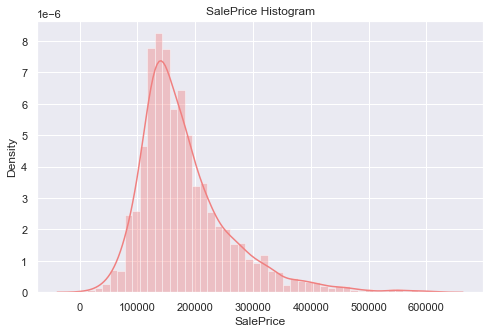

In [16]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(train['SalePrice'], color="lightcoral");
ax.set(title="SalePrice Histogram")


In [17]:
# a quick research shows a few tricks to deal with right-skewed distributions 
# https://rcompanion.org/handbook/I_12.html#:~:text=For%20right%2Dskewed%20data%E2%80%94tail,log%20(constant%20%E2%80%93%20x

train_saleprice_sqrt = np.sqrt(train['SalePrice'])
train_saleprice_cbrt = np.cbrt(train['SalePrice'])
train_saleprice_log = np.log(train['SalePrice'])



In [18]:
stats.skew(train['SalePrice'])


1.5564120909746169

In [19]:
stats.skew(train_saleprice_sqrt)


0.7862294064717241

In [20]:
stats.skew(train_saleprice_log)


-0.14670836711063925

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(417.0644190473226, 86.75812338732638)


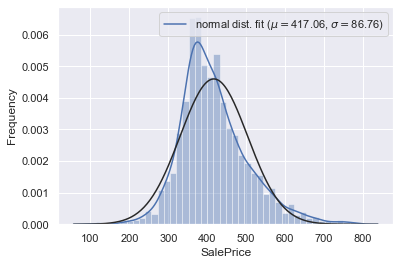

In [21]:
# graphing adapted from https://stackoverflow.com/questions/31413934/howto-get-fit-parameters-from-seaborn-distplot-fit

sns.distplot(train_saleprice_sqrt, fit=stats.norm);
print(stats.norm.fit(train_saleprice_sqrt))

(mu, sigma) = stats.norm.fit(train_saleprice_sqrt)
# Legend and labels 
plt.legend(["normal dist. fit ($\mu=${0:.2f}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.ylabel('Frequency');

(55.56137424840189, 7.636249844222816)


/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


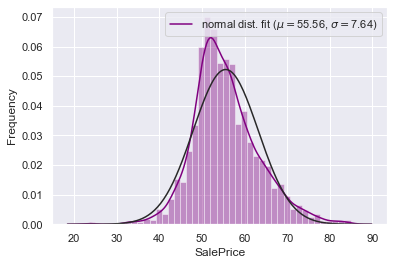

In [22]:
sns.distplot(train_saleprice_cbrt, fit=stats.norm, color='purple');
print(stats.norm.fit(train_saleprice_cbrt))

(mu, sigma) = stats.norm.fit(train_saleprice_cbrt)
# print(stats.norm.fit(train_saleprice_sqrt))
# Legend and labels 
plt.legend(["normal dist. fit ($\mu=${0:.2f}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.ylabel('Frequency');

(12.024396927855069, 0.4112161317472311)


/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


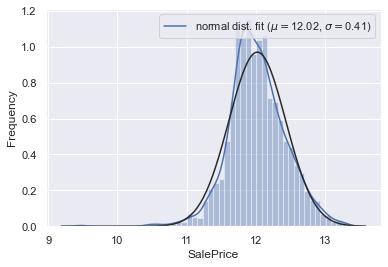

In [23]:
sns.distplot(train_saleprice_log, fit=stats.norm)
print(stats.norm.fit(train_saleprice_log))
(mu, sigma) = stats.norm.fit(train_saleprice_log)
# print(stats.norm.fit(train_saleprice_sqrt))
# Legend and labels 
plt.legend(["normal dist. fit ($\mu=${0:.2f}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.ylabel('Frequency');

In [24]:
train.shape

(2051, 81)

In [25]:
train['SalePrice_norm'] = np.log(train['SalePrice'])
train['SalePrice_norm']

0       11.779129
1       12.301383
2       11.599103
3       12.066811
4       11.838626
          ...    
2046    12.607366
2047    11.320554
2048    12.083905
2049    11.877569
2050    12.149502
Name: SalePrice_norm, Length: 2051, dtype: float64

In [26]:
train_norm = train.copy()
train_norm.head()
train_norm.shape

(2051, 82)

## Eliminate outliers

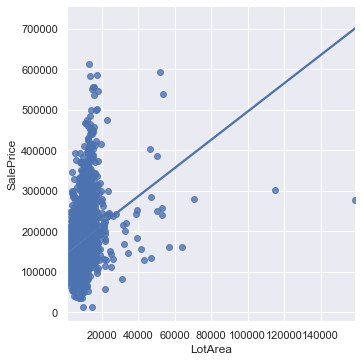

In [27]:
sns.lmplot(y = 'SalePrice', x = 'LotArea', data = train_norm, ci = False);

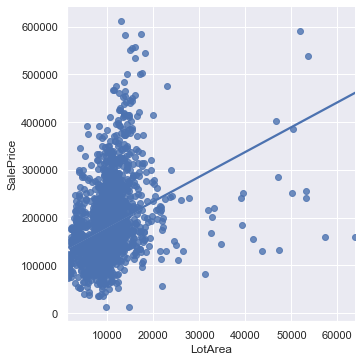

In [28]:
train_norm.drop(train_norm[(train_norm['LotArea']> train_norm['LotArea'].quantile(0.999))].index, inplace=True)

sns.lmplot(y = 'SalePrice', x = 'LotArea', data = train_norm, ci = False);

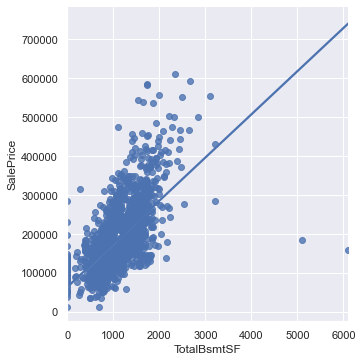

In [29]:
sns.lmplot(y = 'SalePrice', x = 'TotalBsmtSF', data = train_norm, ci = False);

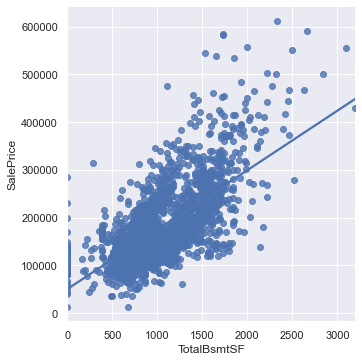

In [30]:
train_norm.drop(train_norm[(train_norm['TotalBsmtSF']> train_norm['TotalBsmtSF'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = 'TotalBsmtSF', data = train_norm, ci = False);

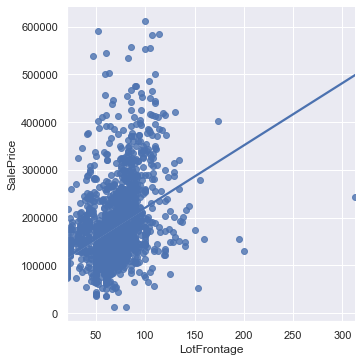

In [31]:
sns.lmplot(y = 'SalePrice', x = 'LotFrontage', data = train_norm, ci = False);

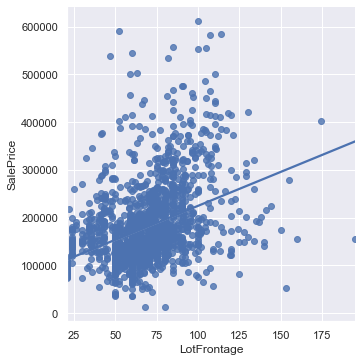

In [32]:
train_norm.drop(train_norm[(train_norm['LotFrontage']> train_norm['LotFrontage'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = 'LotFrontage', data = train_norm, ci = False);

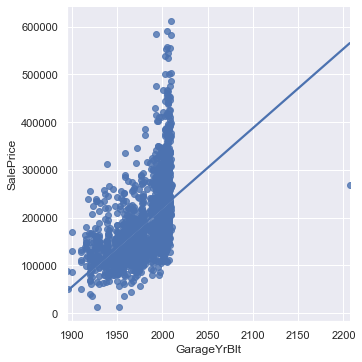

In [33]:

sns.lmplot(y = 'SalePrice', x = 'GarageYrBlt', data = train_norm, ci = False);


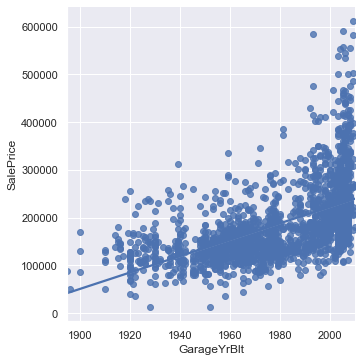

In [34]:
train_norm.drop(train_norm[(train_norm['GarageYrBlt']> 2020)].index, inplace=True)

sns.lmplot(y = 'SalePrice', x = 'GarageYrBlt', data = train_norm, ci = False);


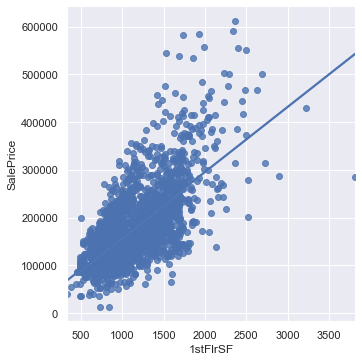

In [35]:
sns.lmplot(y = 'SalePrice', x = '1stFlrSF', data = train_norm, ci = False);

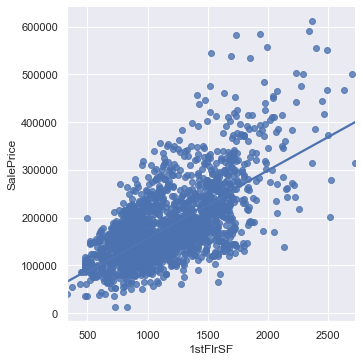

In [36]:
train_norm.drop(train_norm[(train_norm['1stFlrSF']> train_norm['1stFlrSF'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = '1stFlrSF', data = train_norm, ci = False);

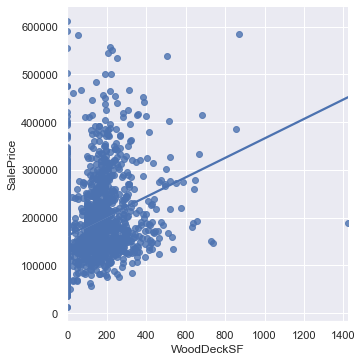

In [37]:

sns.lmplot(y = 'SalePrice', x = 'WoodDeckSF', data = train_norm, ci = False);

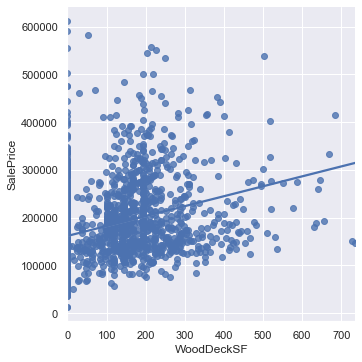

In [38]:
train_norm.drop(train_norm[(train_norm['WoodDeckSF']> train_norm['WoodDeckSF'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = 'WoodDeckSF', data = train_norm, ci = False);

In [39]:
train_nr_out = train_norm.copy()
train_nr_out.to_csv('train_norm.csv')
train_nr_out.shape

(2036, 82)

## Correct Skewness for all features

In [40]:
big_df = pd.concat([train_nr_out, test], axis=0)
big_df.reset_index(inplace=True)
big_df.columns

Index(['index', 'Id', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageC

In [41]:
big_df.drop(columns=['index', 'Id', 'PID', 'Street', 'Alley', 'MiscFeature', 'Utilities', 'Fence', 'PoolQC'], axis=1, inplace=True)
big_df.head()

MSSubClass MSZoning  LotFrontage  LotArea LotShape LandContour LotConfig  \
0          60       RL          NaN    13517      IR1         Lvl   CulDSac   
1          60       RL         43.0    11492      IR1         Lvl   CulDSac   
2          20       RL         68.0     7922      Reg         Lvl    Inside   
3          60       RL         73.0     9802      Reg         Lvl    Inside   
4          50       RL         82.0    14235      IR1         Lvl    Inside   

  LandSlope Neighborhood Condition1  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0       Gtl       Sawyer       RRAe  ...             0         0           0   
1       Gtl      SawyerW       Norm  ...             0         0           0   
2       Gtl        NAmes       Norm  ...             0         0           0   
3       Gtl       Timber       Norm  ...             0         0           0   
4       Gtl      SawyerW       Norm  ...             0         0           0   

   PoolArea  MiscVal  MoSold  YrSold SaleType SalePrice SalePrice_norm  
0         0        0       3    2010      WD   130500.0      11.779129  
1         0        0       4    2009      WD   220000.0      12.301383  
2         0        0       1    2010      WD   109000.0      11.599103  
3         0        0       4    2010      WD   174000.0      12.066811  
4         0        0       3    2010      WD   138500.0      11.838626  

[5 rows x 74 columns]

In [42]:
X = big_df.drop(columns=['SalePrice', 'SalePrice_norm'], axis=1)
y = big_df['SalePrice_norm']

In [43]:
X.isnull().sum().sort_values(ascending=False).head(30)

FireplaceQu     1421
LotFrontage      485
GarageFinish     159
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageType       157
BsmtExposure      81
BsmtQual          78
BsmtCond          78
BsmtFinType1      78
BsmtFinType2      78
MasVnrType        22
MasVnrArea        22
Electrical         1
GarageCars         1
BsmtFullBath       1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
BsmtHalfBath       1
ExterCond          0
ExterQual          0
Exterior2nd        0
Exterior1st        0
RoofMatl           0
SaleType           0
RoofStyle          0
dtype: int64

In [44]:

fill_none = ['GarageFinish', 'FireplaceQu', 'GarageQual', 'GarageCond','GarageType', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'MasVnrType']
for col in fill_none:
    big_df[col] = big_df[col].fillna("None")


In [45]:
fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF']
for col in fill_zero:
    big_df[col] = big_df[col].fillna(0)

In [46]:
big_df.isnull().sum().sort_values(ascending=False).head(27)

SalePrice_norm    878
SalePrice         878
LotFrontage       485
Electrical          1
MSZoning            0
BsmtCond            0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Exterior2nd         0
Exterior1st         0
Heating             0
Condition1          0
LotArea             0
LotShape            0
LandContour         0
LotConfig           0
dtype: int64

In [47]:
big_df['Electrical'].value_counts() # will fill with mode

SBrkr    2666
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [48]:
big_df['Electrical'] = big_df['Electrical'].fillna('SBrkr')

<AxesSubplot:xlabel='Neighborhood', ylabel='LotFrontage'>

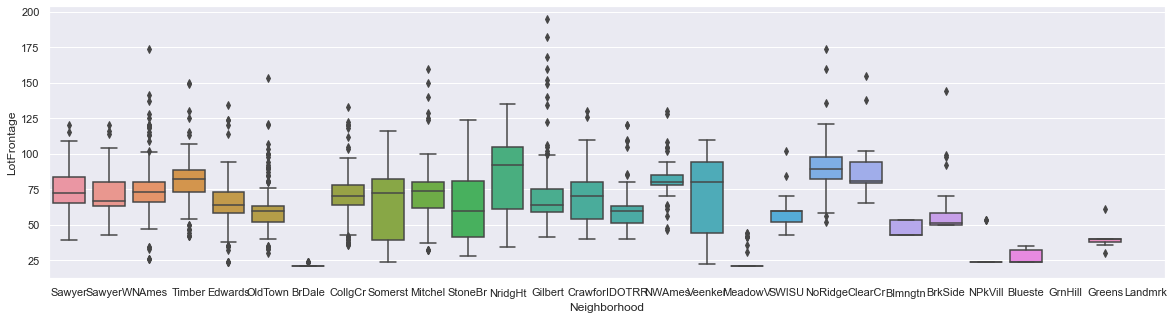

In [49]:
lf_df = pd.concat([big_df['Neighborhood'], big_df['LotFrontage']], axis=1)

plt.figure(figsize=(20,5))
sns.boxplot(x=big_df['Neighborhood'], y=big_df['LotFrontage'])

<AxesSubplot:xlabel='MSZoning', ylabel='LotFrontage'>

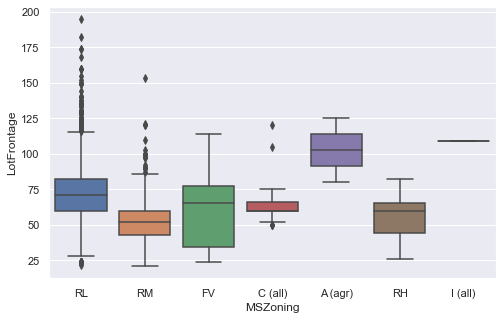

In [50]:
lf_df = pd.concat([big_df['MSZoning'], big_df['LotFrontage']], axis=1)

plt.figure(figsize=(8,5))
sns.boxplot(x=big_df['MSZoning'], y=big_df['LotFrontage'])

<AxesSubplot:xlabel='MSSubClass', ylabel='LotFrontage'>

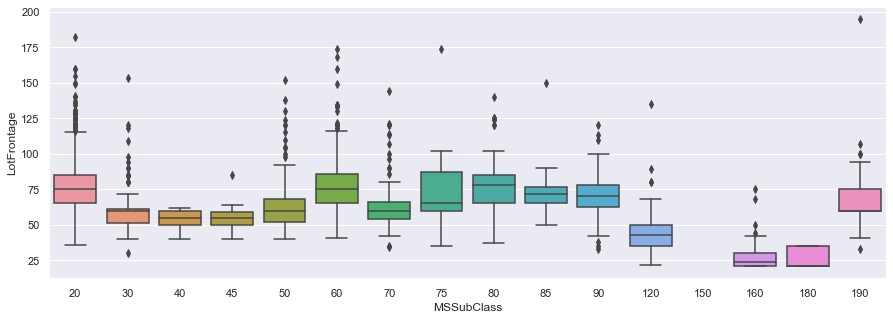

In [51]:
lf_df = pd.concat([big_df['MSSubClass'], big_df['LotFrontage']], axis=1)

plt.figure(figsize=(15,5))
sns.boxplot(x=big_df['MSSubClass'], y=big_df['LotFrontage'])

In [52]:
big_df['LotFrontage'] = big_df.groupby('MSSubClass')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [53]:
big_df.isnull().sum().sort_values(ascending=False)

SalePrice_norm    878
SalePrice         878
LotFrontage         1
TotalBsmtSF         0
BsmtQual            0
                 ... 
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
MSSubClass          0
Length: 74, dtype: int64

In [54]:
big_df['LotFrontage'] = big_df.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [55]:
big_df.isnull().sum().sort_values(ascending=False)

SalePrice_norm    878
SalePrice         878
TotalBsmtSF         0
Foundation          0
Exterior1st         0
                 ... 
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
MSSubClass          0
Length: 74, dtype: int64

In [56]:
big_df.shape

(2914, 74)

In [57]:
big_df['MSSubClass'] = big_df['MSSubClass'].astype(str)
big_df['MoSold'] = big_df['MoSold'].astype(str)
big_df['YrSold'] = big_df['YrSold'].astype(str)

In [58]:
big_df.to_csv('big_df_chk1.csv')

In [59]:
big_df = pd.read_csv('big_df_chk1.csv')
# Binarized Columns

big_df['YesPool'] = big_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
big_df['Yes2F'] = big_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
big_df['YesGarage'] = big_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
big_df['YesBsmt'] = big_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
big_df['YesFireplace'] = big_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [60]:
# simplifying some columns 


big_df['TotalLvgSF'] = big_df['TotalBsmtSF'] + big_df['GrLivArea']
big_df['TotalQuality'] = big_df['OverallQual'] + big_df['OverallCond']
big_df['TotalSF'] = big_df['BsmtFinSF1'] + big_df['BsmtFinSF2'] + big_df['1stFlrSF'] + big_df['2ndFlrSF']
big_df['TotalBath'] = big_df['FullBath'] + big_df['BsmtFullBath'] + 0.5*(big_df['HalfBath'] + big_df['BsmtHalfBath'])
big_df['TotalPorchSF'] = big_df['WoodDeckSF'] + big_df['OpenPorchSF'] + big_df['3SsnPorch'] + big_df['EnclosedPorch'] + big_df['ScreenPorch']

In [61]:
# adding some interactive columns
big_df['TotalLvgSF_Qual'] = big_df['TotalLvgSF']*big_df['TotalQuality'] 
big_df['TotalCondQual'] = big_df['OverallCond']*big_df['OverallQual']

In [62]:
numeric_col = big_df[big_df._get_numeric_data().columns]
numeric_col.columns

Index(['Unnamed: 0', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice_norm', 'YesPool',
       'Yes2F', 'YesGarage', 'YesBsmt', 'YesFireplace', 'TotalLvgSF',
       'TotalQuality', 'TotalSF', 'TotalBath', 'TotalPorchSF',
       'TotalLvgSF_Qual', 'TotalCondQual'],
      dtype='object')

In [63]:
skewed_list = []

for col in list(numeric_col.columns):

    skew = stats.skew(big_df[col])
    if skew > 0.5 or skew < -0.5:
        skewed_list.append(col)
    print(f'{col}:   skew:{skew}')

print(skewed_list)

Unnamed: 0:   skew:0.0
MSSubClass:   skew:1.3524258840016117
LotFrontage:   skew:0.5289383448624689
LotArea:   skew:14.459765542122382
OverallQual:   skew:0.18363115533677557
OverallCond:   skew:0.5722594714563014
YearBuilt:   skew:-0.6017000568055284
YearRemod/Add:   skew:-0.44797861863923083
MasVnrArea:   skew:2.6076686413858297
BsmtFinSF1:   skew:0.8327112732563352
BsmtFinSF2:   skew:4.113931479136624
BsmtUnfSF:   skew:0.921667666313335
TotalBsmtSF:   skew:0.34853132095657013
1stFlrSF:   skew:0.8058060406943611
2ndFlrSF:   skew:0.8588497847219794
LowQualFinSF:   skew:12.078202716583714
GrLivArea:   skew:0.9417624132100568
BsmtFullBath:   skew:0.6134872157984879
BsmtHalfBath:   skew:3.9567077602376535
FullBath:   skew:0.17236583301890707
HalfBath:   skew:0.6982257750130989
BedroomAbvGr:   skew:0.31582808179802124
KitchenAbvGr:   skew:4.2979924748771055
TotRmsAbvGrd:   skew:0.6996931234106242
Fireplaces:   skew:0.7368394957388151
GarageYrBlt:   skew:-3.902904890500826
GarageCars:   sk

In [64]:
# remove binary columns
skewed_list.remove('YesPool')

skewed_list.remove('YesBsmt')
skewed_list.remove('YesGarage')

In [65]:
def max_boxcox1p(df, col): 
    max_lambda = stats.boxcox_normmax(df[col]+1)
    df[col] = boxcox1p(df[col], max_lambda)
    return df[col]


for col in skewed_list:  
    max_boxcox1p(big_df, col)

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [66]:
big_df.head()

Unnamed: 0  MSSubClass MSZoning  LotFrontage    LotArea LotShape  \
0           0    6.607841       RL    31.188031  20.774202      IR1   
1           1    6.607841       RL    20.450934  20.123055      IR1   
2           2    4.300278       RL    28.964221  18.688021      Reg   
3           3    6.607841       RL    30.558474  19.499814      Reg   
4           4    6.182485       RL    33.357589  20.985146      IR1   

  LandContour LotConfig LandSlope Neighborhood  ... YesGarage YesBsmt  \
0         Lvl   CulDSac       Gtl       Sawyer  ...         1       1   
1         Lvl   CulDSac       Gtl      SawyerW  ...         1       1   
2         Lvl    Inside       Gtl        NAmes  ...         1       1   
3         Lvl    Inside       Gtl       Timber  ...         1       1   
4         Lvl    Inside       Gtl      SawyerW  ...         1       1   

  YesFireplace TotalLvgSF  TotalQuality    TotalSF  TotalBath  TotalPorchSF  \
0            0  49.515469     71.648725  14.044537        2.5     16.011841   
1            1  56.463618     55.278932  15.037011        3.5     22.730004   
2            0  48.672520     55.278932  13.685267        2.0     17.932285   
3            0  45.839009     40.801625  13.050612        2.5     27.771664   
4            0  48.738857     71.648725  13.052636        2.0     19.526771   

  TotalLvgSF_Qual TotalCondQual  
0      136.565694            48  
1      145.741676            35  
2      126.454766            35  
3      111.153401            25  
4      134.523344            48  

[5 rows x 87 columns]

In [88]:
big_norm_df = big_df.copy()
big_norm_df = pd.read_csv('big_norm_df.csv')

In [89]:
big_norm_df.drop(columns='Unnamed: 0', inplace=True)

In [90]:
big_norm_df.isnull().sum().sort_values(ascending=False)

SalePrice_norm    878
SalePrice         878
TotalCondQual       0
MasVnrType          0
MasVnrArea          0
                 ... 
GarageFinish        0
GarageCars          0
GarageArea          0
GarageQual          0
Unnamed: 0.1        0
Length: 87, dtype: int64

# Processing and modeling

## RidgeCV

In [91]:
X = big_norm_df.drop(columns=['SalePrice', 'SalePrice_norm'])


In [92]:
features = [col for col in X.columns if col not in numeric_col]
X = pd.get_dummies(data=X, drop_first=True, columns=features)


In [93]:
X = pd.DataFrame(X)
Xtrain = X.iloc[:2036, :] 
Xtest = X.iloc[2036:, :]
y = big_norm_df['SalePrice_norm'].iloc[:2036]
X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size = .1, random_state = 42)
X_train.shape


(1832, 3176)

In [94]:
kf = KFold(n_splits=20, random_state=42, shuffle=True)
r_alphas = np.logspace(0.000001, 5, 100)
ridge_pipe = Pipeline([('sc', StandardScaler()), ('ridgeCV', RidgeCV(alphas=r_alphas, cv=kf))])
ridge_pipe

Pipeline(steps=[('sc', StandardScaler()),
                ('ridgeCV',
                 RidgeCV(alphas=array([1.00000230e+00, 1.12332659e+00, 1.26185973e+00, 1.41747733e+00,
       1.59228631e+00, 1.78865344e+00, 2.00923735e+00, 2.25702455e+00,
       2.53536986e+00, 2.84804183e+00, 3.19927376e+00, 3.59382102e+00,
       4.03702543e+00, 4.53488758e+00, 5.09414809e+00, 5.72237884e+00,
       6.42808553e+00, 7.22082279e+00, 8.11132...
       1.09749925e+04, 1.23284726e+04, 1.38488692e+04, 1.55567672e+04,
       1.74752901e+04, 1.96304129e+04, 2.20513141e+04, 2.47707705e+04,
       2.78256011e+04, 3.12571658e+04, 3.51119247e+04, 3.94420679e+04,
       4.43062218e+04, 4.97702426e+04, 5.59081083e+04, 6.28029203e+04,
       7.05480280e+04, 7.92482935e+04, 8.90215106e+04, 1.00000000e+05]),
                         cv=KFold(n_splits=20, random_state=42, shuffle=True)))])

In [95]:
ridge_train = ridge_pipe.fit(X_train, y_train)
y_trainpred = ridge_pipe.predict(X_train)

In [96]:
# RMSE for training
mean_squared_error(y_train, (y_trainpred), squared=False)

0.008178723255810295

In [97]:
y_testpred = ridge_pipe.predict(X_test)

In [98]:
# RMSE for testing
mean_squared_error(y_test, y_testpred, squared=False)

0.10078574386398526

## LassoCV

In [99]:
lasso_pipe = Pipeline([('sc', StandardScaler()), ('lassoCV', LassoCV(alphas=r_alphas, cv=kf))])
lasso_pipe
lasso_train = lasso_pipe.fit(X_train, y_train)
y_trainpred = lasso_pipe.predict(X_train)
mean_squared_error(y_train, (y_trainpred), squared=False)

0.4089612554992541

In [ ]:
y_testpred = lasso_pipe.predict(X_test)
mean_squared_error(y_test, y_testpred, squared=False)

# Preparing Sample submission

In [ ]:
submission7 = pd.read_csv("datasets/submission_1.csv")
submission7.shape
Xtest.shape

In [ ]:
submission7.iloc[:, 1] = np.expm1(ridge_pipe.predict(Xtest))

submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 50000 else x*1.3)
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x < 6500000 else x*1.075)

submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission7b.csv", index=False)

In [ ]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 150000 else x*1.05)
submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission7a.csv", index=False)

In [ ]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 1500000 else x*1.05)
submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission8.csv", index=False)

In [ ]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 60000 else x*1.25)
submission7.to_csv("submission9.csv", index=False)

In [ ]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 150000 else x*1.05)
submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission1.csv", index=False)

In [ ]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 150000 else x*1.05)
submission7['SalePrice'] *= 1.00175
submission7.to_csv("submission2.csv", index=False)

In [ ]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 60000 else x*1.3)
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x < 6000000 else x*1.075)submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission3.csv", index=False)

# Conclusion


- How can be best predict the housing prices by deep-cleaning our data? 

1. eliminate outliers
2. combining interrelated features to simply the model
3. transform the data to follow standard distribution 
